# Titanic
## Predict survival on the Titanic using Gradient Boost


# Load data into Pandas DataFrame

In [34]:
import pandas as pd

# Read into DataFrames
train = pd.read_csv("titanic/train.csv")
test = pd.read_csv("titanic/test.csv")

# At first lets check the train DataFrame
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


# Check for `null` values

In [35]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Null values found in `Age: 177`, `Cabin: 687`, `Embarked: 2`

# Check data types

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Check distribution of `Age` before imputing null values

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


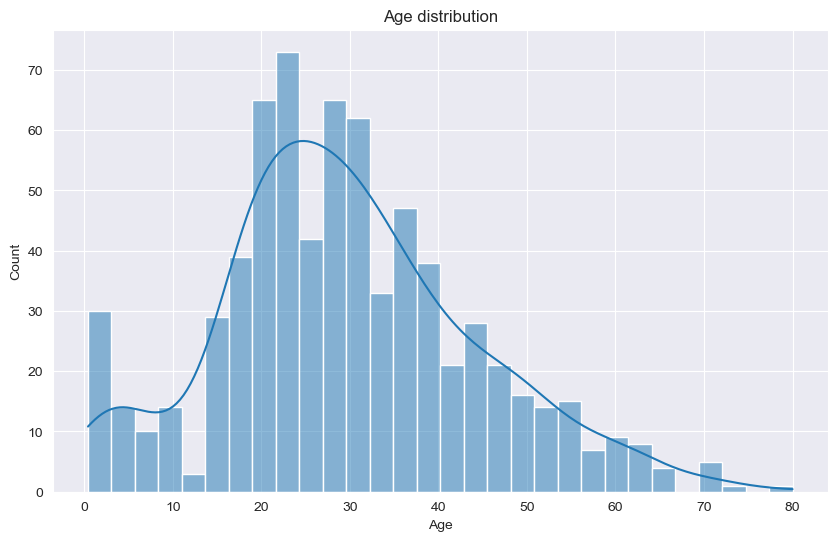

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot a histogram with Age variable
plt.figure(figsize=(10,6))
sns.histplot(train["Age"], bins=30, kde=True)
plt.title("Age distribution")
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Impute null values of `Age` where distribution is right-skewed

### When we get right-skewed distribution of a numerical variable the better practice is use `median` value for imputing missing values. We can't use `mean` value because it will not represent the central tendency of the distribution, because the mean value will come from the right area of distribution.
### But for the this time I will use PMM (Predictive Mean Matching) to impute those values because this technique especially good for non-normally distributed  or skewed data.

In [40]:
from fancyimpute import IterativeImputer

# Create imputer
imputer = IterativeImputer(imputation_order='random', random_state=0)

# Impute train's Age variable
imputed_data = imputer.fit_transform(train[["Age"]])
train['Age'] = pd.DataFrame(imputed_data, columns=["Age"]).astype(int)

# Impute test's Age variable
test_imputed_data = imputer.fit_transform(test[["Age"]])
test['Age'] = pd.DataFrame(test_imputed_data, columns=["Age"]).astype(int)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,30,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,30,0,0,359309,8.0500,NaN,S


In [39]:
"" 

''